## Data Set up

In [1]:
# Linking up Google Colab to Google Drive to get the csv file
from google.colab import drive

drive.mount('/content/drive')

file_name = 'Copy of starcraft_player_data.csv'

Mounted at /content/drive


In [2]:
# Create pandas dataframe
import pandas as pd

starcraft_df = pd.read_csv(f'/content/drive/MyDrive/{file_name}')

starcraft_df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


## First Data Exploration Time!

In [3]:
## First, I would like to see a visualization of the distribution for the LeagueIndex, to see if we follow a normal distribution in the classes

import scipy
import seaborn

ranks_count = starcraft_df.LeagueIndex.value_counts()

print(ranks_count)

4    811
5    806
6    621
3    553
2    347
1    167
8     55
7     35
Name: LeagueIndex, dtype: int64


<Axes: xlabel='LeagueIndex', ylabel='count'>

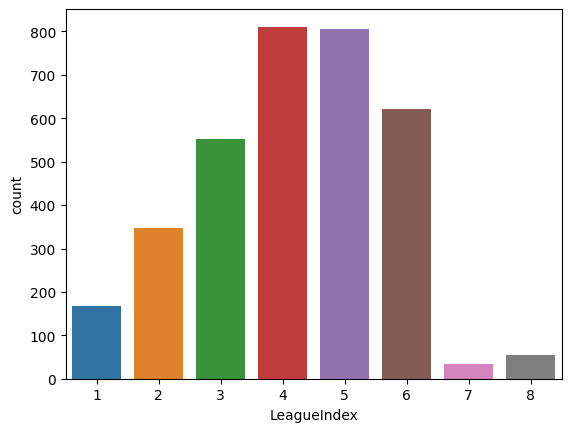

In [4]:
seaborn.countplot(starcraft_df, x = 'LeagueIndex')

As we can see here, It follows a bell curve from class 1 to 6, but there are big outliers in 7 and 8. This is probably a good representation in real life as 7-8 stands for more of a professional league. The Shapiro and the Kolmogorov-Smirnov tests are used to statistically show whether it follows a normal distribution or not. The model chosen later on can be dependent on this factor.

In [5]:
# Default confidence level of the test are 95%

ks_test = scipy.stats.kstest(starcraft_df.LeagueIndex, 'norm')
shapiro_test = scipy.stats.shapiro(starcraft_df.LeagueIndex)

# If p_value is higher than 0.05, then we can conclude that it can be normally distributed

ks_test.pvalue, shapiro_test.pvalue

(0.0, 2.2302645134601645e-33)

Because the p values that came back were not greater than 0.05, I can assume that the differences in classes 1 and 2 to classes 7 and 8 may be affecting what would be a normal distribution of the data. From here, I may decide whether to add dummy data to fill in 7 and 8 using averages across other features should I want to use techniques meant for normal distributed data. For now, I'd like to get the correlation between all the features to the League Index.

In [6]:
starcraft_df.corr().LeagueIndex.sort_values(ascending = False)

<ipython-input-6-c684097342d1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  starcraft_df.corr().LeagueIndex.sort_values(ascending = False)


LeagueIndex             1.000000
APM                     0.662309
NumberOfPACs            0.612192
AssignToHotkeys         0.531125
SelectByHotkeys         0.490599
UniqueHotkeys           0.351213
MinimapAttacks          0.312544
WorkersMade             0.295643
MinimapRightClicks      0.233231
TotalMapExplored        0.220676
ComplexUnitsMade        0.148834
ComplexAbilitiesUsed    0.145733
ActionsInPAC            0.143121
UniqueUnitsMade         0.133508
GameID                  0.102601
GapBetweenPACs         -0.553246
ActionLatency          -0.673939
Name: LeagueIndex, dtype: float64

In [7]:
len(starcraft_df)

3395

With the length of our dataset being over 3000, I can assume that this can be labeled as a large dataset and that I can remove GapBetweenPACs and ActionLatency because it does not seem to statistically important for our results and I would like to remove unneccessary features. I'll evaluate on whether there may be duplicate columns in the data based on a heatmap from the correlation among all columns for further future removal.

<ipython-input-8-761ec7344dde>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  seaborn.heatmap(starcraft_df.corr())


<Axes: >

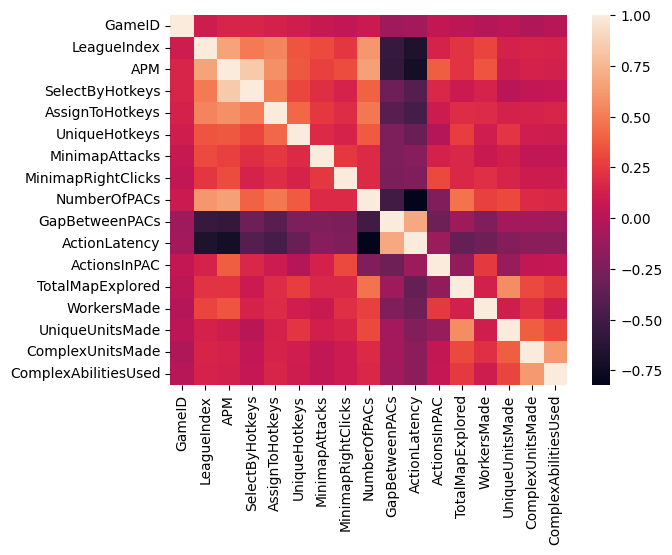

In [8]:
seaborn.heatmap(starcraft_df.corr())

There's high correlations between APM and to columns that suggests that an action is done in a keyframe. This makes sense since it's recording the average distribution of actions in a keyframe. Does not seem to be concerning.

Now, I want to find out the columns that have missing data. While creating the heatmap, it appears that columns Age, HoursPerWeek, and TotalHours were not included.

In [9]:
starcraft_df.Age.value_counts()['?']

55

In [10]:
starcraft_df.HoursPerWeek.value_counts()['?']

56

In [11]:
starcraft_df.TotalHours.value_counts()['?']

57

I believe that a common assumption when it comes to the world of esports is that there is amount of effort players put in to be good at what they do. This assumption also comes from the infamous 10,000 Hours rule. In addition, it is also a common assumption that the younger a video game player is, they typically have more time to play to build up their mechanics for the game. An older player may not have the same reaction speed or have different focuses. Therefore, these columns are expected to still add value to our data. The good thing is that the amount of data, if assumed that they are row-independent, it accounts for about 4% of our data, which is not a huge loss. 

## Some Data Clean Up

In [12]:
# First I want to investigate into the issue of the missing information from the '?' for some columns

temp_df = starcraft_df.loc[:][starcraft_df['LeagueIndex'] == 8]

temp_df.Age.value_counts()['?'], temp_df.HoursPerWeek.value_counts()['?'], temp_df.TotalHours.value_counts()['?']

# UPDATE: Apply a change to HoursPerWeek to 70, set Age to 0 and TotalHours to 0.
# Age and TotalHours is dropped in the future, so only changes needed is HoursPerWeek

temp_df.loc[:, 'HoursPerWeek'] = temp_df['HoursPerWeek'].replace({"?": 70})
temp_df.loc[: ,'Age'] = temp_df['Age'].replace({"?": 0})
temp_df.loc[:,'TotalHours'] = temp_df['TotalHours'].replace({"?": 0})

starcraft_df = starcraft_df.drop(temp_df.index)
starcraft_df = pd.concat([starcraft_df, temp_df], ignore_index = True)

starcraft_df[starcraft_df['LeagueIndex'] == 8].head()

<ipython-input-12-71b9cb4d470a>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  temp_df.loc[:, 'HoursPerWeek'] = temp_df['HoursPerWeek'].replace({"?": 70})
<ipython-input-12-71b9cb4d470a>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  temp_df.loc[: ,'Age'] = temp_df['Age'].replace({"?": 0})
<ipython-input-12-71b9cb4d470a>:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals`

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3340,10001,8,0,70,0,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.0
3341,10005,8,0,70,0,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.0
3342,10006,8,0,70,0,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.0
3343,10015,8,0,70,0,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.0
3344,10016,8,0,70,0,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.0


In [13]:
starcraft_df = starcraft_df.drop(starcraft_df[starcraft_df.HoursPerWeek == '?'].index)

len(starcraft_df)

3394

In [14]:
starcraft_df = starcraft_df.drop(starcraft_df[starcraft_df.TotalHours == '?'].index)

len(starcraft_df)

3393

In [15]:
starcraft_df.LeagueIndex.value_counts()

4    811
5    804
6    621
3    553
2    347
1    167
8     55
7     35
Name: LeagueIndex, dtype: int64

Retained the professional class and deleted only 2 pieces of data that might not work

Now, I want to clean up the columns which do not have a strong statistical correlation and can be ignored. 

In [16]:
temp_df = starcraft_df.drop(['GapBetweenPACs', 'ActionLatency'], axis = 1)

starcraft_df = temp_df

## Second Round of Data Exploration

Taking a look at what the small changes have done and whether we can get back good results from editting Age, HoursPerWeek and TotalHours

In [17]:
starcraft_df.corr().LeagueIndex.sort_values(ascending = False)

<ipython-input-17-c684097342d1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  starcraft_df.corr().LeagueIndex.sort_values(ascending = False)


LeagueIndex             1.000000
APM                     0.662438
NumberOfPACs            0.612260
AssignToHotkeys         0.531105
SelectByHotkeys         0.490604
UniqueHotkeys           0.351461
MinimapAttacks          0.312762
WorkersMade             0.295754
MinimapRightClicks      0.233432
TotalMapExplored        0.220534
ComplexUnitsMade        0.148875
ComplexAbilitiesUsed    0.145656
ActionsInPAC            0.143398
UniqueUnitsMade         0.133625
GameID                  0.102831
Name: LeagueIndex, dtype: float64

In reality, GameID probably would not do well on new data and therefore, we can also remove this. 

In [18]:
starcraft_df.Age

0       27
1       23
2       30
3       19
4       32
        ..
3390     0
3391     0
3392     0
3393     0
3394     0
Name: Age, Length: 3393, dtype: object

In [19]:
starcraft_df.HoursPerWeek

0       10
1       10
2       10
3       20
4       10
        ..
3390    70
3391    70
3392    70
3393    70
3394    70
Name: HoursPerWeek, Length: 3393, dtype: object

In [20]:
starcraft_df.TotalHours

0       3000
1       5000
2        200
3        400
4        500
        ... 
3390       0
3391       0
3392       0
3393       0
3394       0
Name: TotalHours, Length: 3393, dtype: object

One issue here that is affecting getting the correlation of this and most likely still causing the pop-up of the deprecated warning is that the dtype of these columns are objects rather than integers/floats.

## Some more data clean up and transformation on columns

In [21]:
temp_df = starcraft_df.drop('GameID', axis = 1)

In [22]:
temp_df['Age'] = temp_df['Age'].astype(int)
temp_df['HoursPerWeek'] = temp_df['HoursPerWeek'].astype(int)
temp_df['TotalHours'] = temp_df['TotalHours'].astype(int)

In [23]:
starcraft_df = temp_df

## Checking if data is ok for first attempt of model building

In [24]:
starcraft_df.corr().LeagueIndex

LeagueIndex             1.000000
Age                    -0.277910
HoursPerWeek            0.339824
TotalHours              0.020324
APM                     0.662438
SelectByHotkeys         0.490604
AssignToHotkeys         0.531105
UniqueHotkeys           0.351461
MinimapAttacks          0.312762
MinimapRightClicks      0.233432
NumberOfPACs            0.612260
ActionsInPAC            0.143398
TotalMapExplored        0.220534
WorkersMade             0.295754
UniqueUnitsMade         0.133625
ComplexUnitsMade        0.148875
ComplexAbilitiesUsed    0.145656
Name: LeagueIndex, dtype: float64

Appears that though an assumption was made on the Age, it serves to not have much statistical correlation to a person's rank. In addition, the total hours played does not have much significance in the dataset but the hours played on a weekly basis does.

In [25]:
temp_df = starcraft_df.drop(['Age', 'TotalHours'], axis = 1)

starcraft_df = temp_df

In [26]:
starcraft_df.corr().LeagueIndex.sort_values(ascending = False)

LeagueIndex             1.000000
APM                     0.662438
NumberOfPACs            0.612260
AssignToHotkeys         0.531105
SelectByHotkeys         0.490604
UniqueHotkeys           0.351461
HoursPerWeek            0.339824
MinimapAttacks          0.312762
WorkersMade             0.295754
MinimapRightClicks      0.233432
TotalMapExplored        0.220534
ComplexUnitsMade        0.148875
ComplexAbilitiesUsed    0.145656
ActionsInPAC            0.143398
UniqueUnitsMade         0.133625
Name: LeagueIndex, dtype: float64

## Non-Parametric Base Model Testing

After cleaning our data, all remaining features are statistically significant.
While looking through the class distribution, it was determined as not being able to fit as a normal distribution. I will test this by using non-parametric models first.

```
# This is formatted as code
```



In [27]:
import sklearn
from sklearn.model_selection import train_test_split

X = starcraft_df.drop(['LeagueIndex'], axis = 1)
y = starcraft_df.LeagueIndex

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80)

In [28]:
from sklearn.neighbors import KNeighborsClassifier as KNN

neighbors = [1, 5, 10, 15, 20, 25, 30, 50, 100, 200]
results = []
for neighbor in neighbors:
  model = KNN(n_neighbors = neighbor,
              weights = 'uniform')

  model.fit(X_train, y_train)
  results.append(model.score(X_test, y_test))

results

[0.30633284241531666,
 0.33726067746686306,
 0.35051546391752575,
 0.3446244477172312,
 0.35787923416789397,
 0.3593519882179676,
 0.35787923416789397,
 0.3402061855670103,
 0.31958762886597936,
 0.3284241531664212]

Though the results do not come as impressive, it seems adding more neighbors has been an upwards trend.

I'll try another non-parametric algorithm, the Random Forest, to see if there are any significant changes.

In [29]:
from sklearn.ensemble import RandomForestClassifier

trees = [1, 5, 10, 15, 20, 25, 30, 50, 100, 200, 300, 400, 500]
results = []

for tree in trees:
  model = RandomForestClassifier(n_estimators = tree,
                                 criterion = 'entropy',
                                 class_weight = 'balanced',
                                 )
  
  model.fit(X_train, y_train)
  results.append(model.score(X_test, y_test))

results

[0.3166421207658321,
 0.30927835051546393,
 0.36524300441826213,
 0.4005891016200295,
 0.35051546391752575,
 0.41237113402061853,
 0.39911634756995584,
 0.40795287187039764,
 0.39322533136966126,
 0.41237113402061853,
 0.40795287187039764,
 0.40795287187039764,
 0.41237113402061853]

Generally, while testing the random forest classifier, the results have been better than using the KNN Classifier, especially when increasing the number of estimators.

This may be due to:
1. Noise (It was examined earlier that there were several outliers when it came to the classes though we did not examine the features themselves)
2. No exact linear relationship in the classes
3. More data to process

Another thing to note is that the Random Forest training takes longer than the KNN, but the tradeoff in computation speed is not significant.

The last non-parametric base model I'll try with is the SVM Classifier. 

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


regularizations = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]

gamma = [0.0001, 0.001, 0.01, 0.1, 1.0]

grid = {'C': regularizations, 'gamma': gamma}

model = SVC(kernel = 'rbf',
            class_weight = None)

grid_search = GridSearchCV(model, grid, cv=5)

grid_search.fit(X_train, y_train)

grid_search.best_params_


{'C': 50.0, 'gamma': 0.0001}

In [31]:
model = SVC(C = grid_search.best_params_['C'],
            gamma = grid_search.best_params_['gamma'],
            kernel = 'rbf',
            class_weight = None)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.3784977908689249

Performance of the SVM with a RBF kernel still does not perform better than the Random Forest. In addition, making the class weight to 'balanced' causes the test accuracy to drop by 10% while adjusting the class weight on the Random Forest Classifier does not result in any significant changes. This may be caused by the data not being able to separate the classes clearly. 

## Parametric Base Model Testing

I'll do a few tests with parametric classifiers now to see how I can be changing the data further in order to represent the model more accurately. I'll be working with a classic Logistic Regression and a linear SGD Classifier

In [32]:
from sklearn.linear_model import LogisticRegression

regularizations = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
results = []
for c in regularizations:
  model = LogisticRegression(C = c,
                             max_iter = 500,
                             solver = 'newton-cg',
                             penalty = 'l2')
  
  model.fit(X_train, y_train)

  results.append(model.score(X_test, y_test))

results

[0.37702503681885124,
 0.37702503681885124,
 0.37702503681885124,
 0.3755522827687776,
 0.3755522827687776,
 0.38144329896907214,
 0.38144329896907214]

The same problem occurs with the Logistic Regression on the class weights. When changed to 'balanced', the accuracy significantly decreases by 10%.

In [33]:
from sklearn.linear_model import SGDClassifier

alpha_rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
results = []

for alpha in alpha_rates:
  model = SGDClassifier(loss = 'hinge',
                        penalty = 'l2',
                        alpha = alpha,
                        )
  
  model.fit(X_train, y_train)

  results.append(model.score(X_test, y_test))

results

[0.30633284241531666,
 0.3387334315169367,
 0.30927835051546393,
 0.3181148748159057,
 0.3181148748159057]

The SGD Classifier does not perform great at all, but summarizing the results of the tests.

1. The Random Forest Classifier performed the best for the non-parametric classifiers, reaching around 41%.
2. The Logistic Classifier performed the best for the parametric classifiers, which performed similarily to the Random Forest Classifier, sitting at 40% accuracy.
3. There seems to be an issue with when class weights are changed to be balanced despite the classes are inbalanced.

## Further Transformations to Dataset

Proposals for transformations on our data to improve accuracy:
1. Add in dummy data to classes 7 and 8 to replicate 1 and 2 to achieve a normal distribution in classes.
2. To remove the impact of outliers, going to apply a square root on all data other than the label
3. Standardize the data using a StandardScaler.

In [34]:
# Proposal 1: Adding in dummy data is achieved by getting the mean across the class

class_7 = starcraft_df[starcraft_df['LeagueIndex'] == 7]
class_8 = starcraft_df[starcraft_df['LeagueIndex'] == 8]

class_7_mean_avg = class_7.mean()
class_8_mean_avg = class_8.mean()

# going to add approximately 300 samples of 7 and 100 samples of class 8 and observe the changes
dummy_samples_7 = 300
dummy_samples_8 = 100
dummy_df = pd.concat([pd.DataFrame([class_7_mean_avg] * dummy_samples_7), starcraft_df], ignore_index = True)
dummy_df = pd.concat([pd.DataFrame([class_8_mean_avg] * dummy_samples_8), dummy_df], ignore_index = True)

In [35]:
dummy_df.LeagueIndex.value_counts()

4.0    811
5.0    804
6.0    621
3.0    553
2.0    347
7.0    335
1.0    167
8.0    155
Name: LeagueIndex, dtype: int64

In [36]:
starcraft_df.LeagueIndex.value_counts()

4    811
5    804
6    621
3    553
2    347
1    167
8     55
7     35
Name: LeagueIndex, dtype: int64

In [37]:
starcraft_df = dummy_df

In [38]:
len(starcraft_df)

3793

In [84]:
from sklearn import svm
from typing_extensions import dataclass_transform
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import top_k_accuracy_score, accuracy_score

def train_and_score(steps, data):
  pipe = make_pipeline(*steps)
  pipe.fit(data["X_train"], data["y_train"])



  return pipe.predict_proba(data["X_test"]), pipe.predict(data["X_test"])

def experiment_models_with_data_changes(starcraft_df, normalize = False, sqrt = False):
  X_train, X_test, y_train, y_test = train_test_split(starcraft_df.drop('LeagueIndex', axis = 1),
                                                      starcraft_df.LeagueIndex,
                                                      train_size = 0.80)
  
  if sqrt:
    X_train, X_test = np.sqrt(X_train), np.sqrt(X_test)
  
  logistic_classifier = LogisticRegression(C = 1.0,
                                           penalty = 'l2',
                                           solver = 'newton-cg',
                                           )
  
  random_forest = RandomForestClassifier(n_estimators = 500,
                                         criterion = 'entropy',
                                         class_weight = 'balanced')
  
  knn = KNN(n_neighbors = 25, weights = 'uniform')
  
  sgd = SGDClassifier(loss = 'log_loss', penalty = 'l2', alpha = 0.001)
  
  svm = SVC(kernel = 'rbf',
            C = grid_search.best_params_['C'],
            gamma = grid_search.best_params_['gamma'],
            probability = True,
            )
  
  data = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
  
  steps = []
  if normalize:
    steps.append(StandardScaler())
  
  steps.append(logistic_classifier)
  probs_logistic, pred_labels_logistic = train_and_score(steps, data)

  steps[-1] = random_forest
  probs_random_forest, pred_labels_random_forest = train_and_score(steps, data)

  steps[-1] = knn
  probs_knn, pred_labels_knn = train_and_score(steps, data)
  
  steps[-1] = sgd
  probs_sgd, pred_labels_sgd = train_and_score(steps, data)

  steps[-1] = svm
  probs_svm, pred_labels_svm = train_and_score(steps, data)

  return {'logistic_regression_test_acc': accuracy_score(y_test, pred_labels_logistic),
          'logistic_regression_test_k@3_acc': top_k_accuracy_score(y_test, probs_logistic, k = 3),
          'logistic_regression_test_k@2_acc': top_k_accuracy_score(y_test, probs_logistic, k = 2),
          'random_forest_test_acc': accuracy_score(y_test, pred_labels_random_forest),
          'random_forest_test_k@3_acc': top_k_accuracy_score(y_test, probs_random_forest, k = 3),
          'random_forest_test_k@2_acc': top_k_accuracy_score(y_test, probs_random_forest, k = 2),
          'knn_test_acc': accuracy_score(y_test, pred_labels_knn),
          'knn_test_k@3_acc': top_k_accuracy_score(y_test, probs_knn, k = 3),
          'knn_test_k@2_acc': top_k_accuracy_score(y_test, probs_knn, k = 2),
          'sgd_test_acc': accuracy_score(y_test, pred_labels_sgd),
          'sgd_test_k@3_acc': top_k_accuracy_score(y_test, probs_sgd, k = 3),
          'sgd_test_k@2_acc': top_k_accuracy_score(y_test, probs_sgd, k = 2),
          'svm_test_acc': accuracy_score(y_test, pred_labels_svm),
          'svm_test_k@3_acc': top_k_accuracy_score(y_test, probs_svm, k= 3),
          'svm_test_k@2_acc': top_k_accuracy_score(y_test, probs_svm, k= 2),
        }

In [88]:
# Testing dummy_data only
dummy_data_only_scores = experiment_models_with_data_changes(starcraft_df)

# Testing dummy_data with normalization
normed_data_scores = experiment_models_with_data_changes(starcraft_df, normalize = True)

# Testing dummy_data with sqrt scaling
sqrt_data_scores = experiment_models_with_data_changes(starcraft_df, sqrt = True)

# Testing dummy_data with sqrt scaling and normalization
sqrt_and_norm_data_scores = experiment_models_with_data_changes(starcraft_df, sqrt = True, normalize = True)


In [89]:
#Visualize the scores for dummy data only
def visualize_k_scores(scores):

  k1_scores = [scores['logistic_regression_test_acc'],
              scores['random_forest_test_acc'],
              scores['knn_test_acc'],
              scores['sgd_test_acc'],
              scores['svm_test_acc']]

  k2_scores = [scores['logistic_regression_test_k@2_acc'],
               scores['random_forest_test_k@2_acc'],
               scores['knn_test_k@2_acc'],
               scores['sgd_test_k@2_acc'],
               scores['svm_test_k@2_acc']]

  k3_scores = [scores['logistic_regression_test_k@3_acc'],
               scores['random_forest_test_k@3_acc'],
               scores['knn_test_k@3_acc'],
               scores['sgd_test_k@3_acc'],
               scores['svm_test_k@3_acc']]

  scores = [k1_scores, k2_scores, k3_scores]
  k_values = ['top_k@1', 'top_k@2', 'top_k@3']
  data = pd.DataFrame(scores, k_values, columns = ['log_reg', 'rf', 'knn', 'sgd', 'svm'])

  seaborn.lineplot(data=data, palette="tab10", linewidth=2.5)

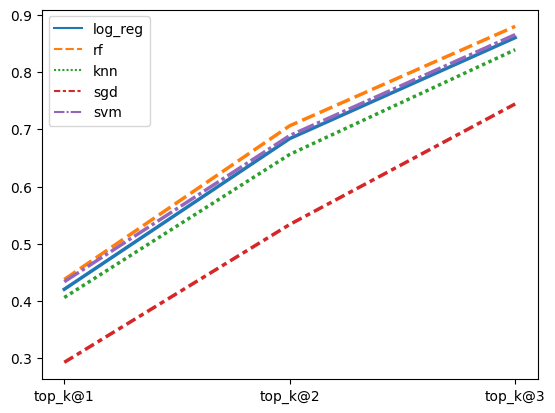

In [90]:
visualize_k_scores(dummy_data_only_scores)

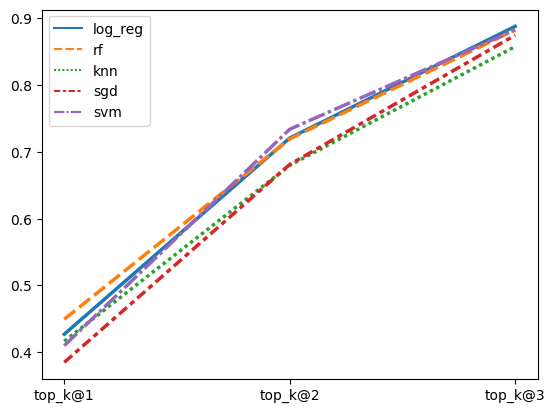

In [91]:
visualize_k_scores(normed_data_scores)

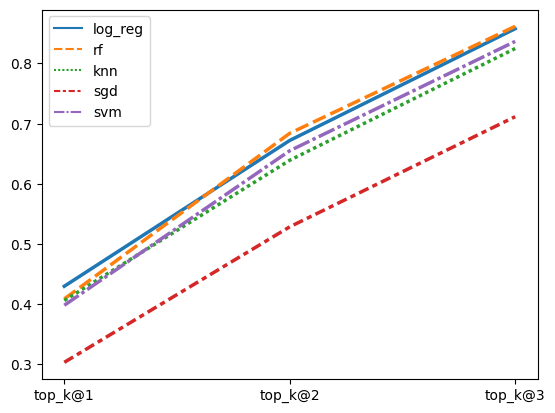

In [92]:
visualize_k_scores(sqrt_data_scores)

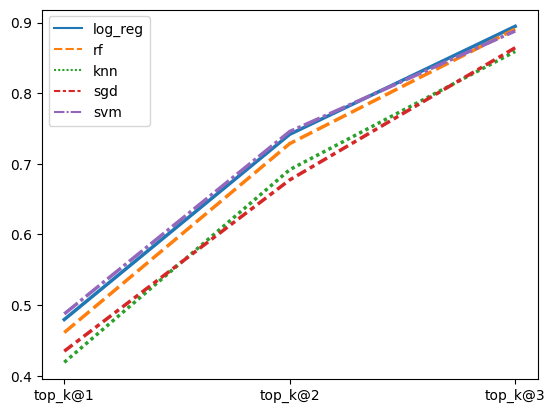

In [93]:
visualize_k_scores(sqrt_and_norm_data_scores)

First Test Analysis: Dummy Data Only
- SGD is still very low in accuracy, meaning that dummy data itself did not affect much.
- Logistic Regression, KNN, SVM, and Random Forest are grouped together, and either perform the same or significantly better than without dummy data.

Second Test Analysis: Dummy Data with Normalized/Standardized Data
- As k increases, SGD is able to get higher than KNN, but still starts with very low accuracy if k == 1
- No significant change overall in all models when k == 1

Third Test Analysis: Dummy Data with Square-Root Transformation
- Generally, made the predictions worse than it was in the other tests.

Fourth Test Analysis: Dummy Data with Square-Root Transformation and Normalized Data
- SVM performs the best, but converges with logistic regression and random forest as k increases.
- Good increase overall across the top models in comparison to the previous tests.

Assumptions:
1. Square root transformation takes away too much data when it is the only transformation, but when outliers are taken away along with standardizing the data, results improve.
2. Adding dummy data is able to give a better normal distribution than previously, increasing each model overall.
3. The data is just not complex enough in order to help distinguish the classes, therefore K@2 accuracy and K@3 accuracy is very high. 

Test:
- Because these models all perform differently, it may be of worth to combine the KNN, SVM, and Random Forest model as estimators with the Logistic Regression as the final estimator in a StackingClassifier.
- I combine the SVM and Random Forest because those are the two best models that have been throughout experimentation. I hope that though K@1 accuracy for KNN is low in comparison to SVM and Random Forest, it may be help in balancing out predictions, preventing overfitting that might be done by SVM and Random Forest.
- Logistic Regression is used as the final estimator since its a simpler model to do for predictions.

In [137]:
from sklearn.ensemble import StackingClassifier

estimators = [
  ('rf', make_pipeline(StandardScaler(),
                       RandomForestClassifier(n_estimators = 500,
                                              criterion = 'entropy',
                                              class_weight = 'balanced',
                                              ),
                       ),
  ),
  ('svm', make_pipeline(StandardScaler(),
                       SVC(kernel = 'rbf',
                           C = grid_search.best_params_['C'],
                           gamma = grid_search.best_params_['gamma'],
                           probability = True,
                          )
                       )
  ),
  ('knn', make_pipeline(StandardScaler(),
                       KNN(n_neighbors = 25, weights = 'uniform')
                       )
  ),
]

final_estimator = make_pipeline(StandardScaler(),
                                LogisticRegression(C = 1.0,
                                              max_iter = 500,
                                              solver = 'newton-cg',
                                              penalty = 'l2'),
                                )

pipe = make_pipeline(StandardScaler(),
                      StackingClassifier(estimators = estimators,
                                         final_estimator = final_estimator,
                                         passthrough = True)
                    )


In [138]:
X_train, X_test, y_train, y_test = train_test_split(starcraft_df.drop('LeagueIndex', axis = 1),
                                                    starcraft_df.LeagueIndex,
                                                    train_size = 0.8)

X_train, X_test = np.sqrt(X_train), np.sqrt(X_test)

pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.5072463768115942

## Non-Technical Conclusion

The final model is able to achieve a 50% accuracy after using common practices to help boost the prediction. Though 50% accuracy is not remarkable, eight separate ranks were classified, meaning that this was not simply a flip of a coin, but rather a dice with 8 sides and being able to get the right answer 50% of the times despite that. 

An issue with the dataset is that there is not enough significant data on higher-tiered players who are at a professional level. By adding dummy data, I was able to replicate what might have been collected, but there are still uncertainities to whether the current data is adequate enough.

In addition, there were several elements to the dataset that were removed to due its irrelevance for future predictions or that it really just had no relation with the rank of the player. 

## Hypothetical for Advising

If more data could be collected, then the following should be prioritized:

1. More data on professional players, classes 7 and 8, need to be collected in order to reflect predictions more correctly.
2. Add a column on HoursPerDay. While TotalHours did not matter in the end, players that play more on a consistent basis might give more insight on their rank as the job of pro players is to get better at the game and to play more. HoursPerWeek had a correlation of over 20%, which is statistically significant, so it could be same with HoursPerDay.
3. Avoid collecting future data concerning Age, GameID, GapBetweenPACs, and Action Latency. These had no indication of one's rank.
4. Instead, collect more data on Mouse or Keyboard activity, whether it be the amount of clicks of a certain button or the movement of the mouse across the game. Though this is generalized as APM, it may be meaningful to differentiate them. 